In [25]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amptorch.gaussian import Gaussian
from amptorch.skorch.model_skorch import FullNN, CustomLoss, TanhLoss
from amptorch.skorch.skorch_data import AtomsDataset, factorize_data, collate_amp, TestDataset
from amptorch.skorch.skorch_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots
from amptorch.skorch import AMP
from amptorch.lj_model import lj_optim
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
from ase.md import Langevin

In [26]:
# Functions needed to allow skorch to report energy and force rmse
def target_extractor(y):
    return (
        (to_numpy(y[0]), to_numpy(y[1]))
        if len(y) == 2
        else (to_numpy(y[0]), to_numpy(y[1]), to_numpy(y[2]))
    )

def energy_score(net, X, y):
    mse_loss = MSELoss(reduction="sum")
    energy_pred = net.infer()[0]
    device = energy_pred.device
    energy_target = torch.tensor(y[0]).to(device)
    num_atoms = torch.tensor(y[1]).to(device)
    dataset_size = len(energy_pred)
    sd_scaling = scalings[0]
    mean_scaling = scalings[1]
    raw_preds = (energy_pred * sd_scaling) + mean_scaling
    raw_preds_per_atom = torch.div(raw_preds, num_atoms)
    raw_targets = (energy_target * sd_scaling) + mean_scaling
    target_per_atom = torch.div(raw_targets, num_atoms)
    energy_loss = mse_loss(raw_preds_per_atom, target_per_atom)
    energy_loss /= dataset_size
    energy_rmse = torch.sqrt(energy_loss)
    return energy_rmse

def forces_score(net, X, y):
    mse_loss = MSELoss(reduction="sum")
    sd_scaling = scalings[0]
    force_pred = net.infer()[1] * sd_scaling
    device = force_pred.device
    num_atoms = torch.tensor(y[1]).to(device)
    force_target = torch.tensor(y[-1], device=device)
    dataset_size = len(num_atoms)
    raw_force_target = force_target * sd_scaling
    num_atoms_force = torch.cat([idx.repeat(int(idx)) for idx in num_atoms])
    num_atoms_force = torch.sqrt(num_atoms_force).reshape(len(num_atoms_force), 1)
    force_pred_per_atom = torch.div(force_pred, num_atoms_force)
    force_targets_per_atom = torch.div(raw_force_target, num_atoms_force)
    force_mse = mse_loss(force_pred_per_atom, force_targets_per_atom)
    force_mse /= 3 * dataset_size
    force_rmse = torch.sqrt(force_mse)
    return force_rmse

In [27]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 6.0

In [28]:
# LJ Optimization
def lj_optimization(images, Gs, label):
    cutoff = Gs["cutoff"]
    p0 = [
        1.33905162,
        0.12290683,
        6.41914719,
        0.64021468,
        0.08010004,
        8.26082762,
        2.29284676,
        0.29639983,
        0.08071821,
    ]
    params_dict = {"C": [], "O": [], "Cu": []}
    lj_model = lj_optim(images, p0, params_dict, cutoff, label)
    fitted_params = lj_model.fit()
    lj_energies, lj_forces, num_atoms = lj_model.lj_pred(
        images, fitted_params, params_dict
    )
    lj_data = [
        lj_energies,
        lj_forces,
        num_atoms,
        fitted_params,
        params_dict,
        lj_model,
    ]
    return lj_data

In [29]:
# Define Training data
label = "skorch_example"
images = ase.io.read("../../datasets/COCu/COCu_pbc_300K.traj", ":100")
lj_data = lj_optimization(images, Gs, label)
forcetraining = True
training_data = AtomsDataset(images, Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=1, lj_data=lj_data)
scalings = training_data.scalings
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

LJ optimization initiated...
Optimizer terminated successfully.
Calculating fingerprints...
Fingerprints Calculated!


In [48]:
import skorch.callbacks.base
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')

LR_schedule = LRScheduler('CosineAnnealingLR', T_max=5)
cp = Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')
load_best_valid_loss = train_end_load_best_valid_loss()


net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 30, 30], device, forcetraining=forcetraining),
    criterion=TanhLoss,
    criterion__force_coefficient=0.3,
    optimizer=torch.optim.Adam,
    lr=1e-2,
    batch_size=10,
    max_epochs=500,
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=True,
    iterator_valid__collate_fn=collate_amp,
    iterator_valid__shuffle=False,
    device=device,
    train_split=CVSplit(0.2),
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ), cp,  load_best_valid_loss, LR_schedule
    ],
)

In [49]:
# Define calculator and train
calc = AMP(training_data, net, label=label)
calc.train(overwrite=True)

  epoch    energy_score    forces_score    train_loss    valid_loss    cp     dur
-------  --------------  --------------  ------------  ------------  ----  ------
      1          0.9405        167.0804       19.4631        3.2366     +  0.6403
      2          0.1734          5.0927        1.2816        0.9758     +  0.6460
      3          0.0618          0.1386        0.6142        0.3623     +  0.6094
      4          0.0732          0.0353        1.4973        0.3849        0.5610
      5          0.0809          0.0485        0.4025        0.3568     +  0.5362
      6          0.0629          0.0463        0.3861        0.3568        0.6499
      7          0.0720          0.0434        0.3765        0.3511     +  0.5972
      8          0.0545          0.0462        0.3822        0.3438     +  0.5299
      9          0.0559          0.0454        0.3599        0.3313     +  0.5569
     10          0.0519          0.0489        0.3519        0.3138     +  0.6182
     11         

     89          0.0251          0.0517        0.2899        0.3334        0.5536
     90          0.0220          0.0478        0.2891        0.3669        0.5708
     91          0.0330          0.0505        0.2931        0.3624        0.6072
     92          0.0235          0.0506        0.2908        0.3048        0.6057
     93          0.0193          0.0466        0.2910        0.2848        0.5711
     94          0.0183          0.0484        0.2863        0.2923        0.6674
     95          0.0278          0.0535        0.2850        0.2947        0.5507
     96          0.0190          0.0568        0.2844        0.2947        0.4867
     97          0.0169          0.0508        0.2844        0.2989        0.5756
     98          0.0241          0.0473        0.2842        0.3157        0.5169
     99          0.0232          0.0490        0.2887        0.3410        0.5000
    100          0.0234          0.0538        0.2869        0.3491        0.5412
    101         

    186          0.0243          0.0507        0.2624        0.2571        0.7073
    187          0.0210          0.0480        0.2620        0.2610        0.5890
    188          0.0267          0.0563        0.2630        0.2654        0.6284
    189          0.0250          0.0533        0.2638        0.2691        0.5853
    190          0.0231          0.0617        0.2635        0.2608        0.5869
    191          0.0219          0.0547        0.2700        0.2514        0.5842
    192          0.0177          0.0534        0.2684        0.2754        0.6025
    193          0.0325          0.0480        0.2669        0.2897        0.5713
    194          0.0265          0.0646        0.2648        0.2957        0.6119
    195          0.0205          0.0537        0.2633        0.2910        0.5840
    196          0.0215          0.0564        0.2612        0.2910        0.4999
    197          0.0224          0.0574        0.2605        0.2836        0.5653
    198         

    285          0.0271          0.0610        0.2653        0.3954        0.6047
    286          0.0289          0.0531        0.2610        0.3954        0.6564
    287          0.0210          0.0496        0.2618        0.3706        0.9995
    288          0.0203          0.0441        0.2650        0.3382        0.7314
    289          0.0258          0.0600        0.2633        0.3272        0.7227
    290          0.0306          0.0484        0.2658        0.3649        0.5628
    291          0.0291          0.0627        0.2670        0.4232        0.5473
    292          0.0471          0.0559        0.2691        0.4294        0.7291
    293          0.0360          0.0524        0.2692        0.4347        0.7603
    294          0.0239          0.0528        0.2673        0.4015        0.8288
    295          0.0255          0.0451        0.2627        0.4109        0.8818
    296          0.0230          0.0484        0.2596        0.4109        0.7643
    297         

    385          0.0338          0.0481        0.2643        0.3715        0.6497
    386          0.0228          0.0563        0.2643        0.3715        0.8075
    387          0.0166          0.0555        0.2691        0.3639        0.7517
    388          0.0250          0.0523        0.2690        0.3717        0.7475
    389          0.0225          0.0484        0.2710        0.3647        0.7057
    390          0.0238          0.0542        0.2779        0.3683        0.5901
    391          0.0270          0.0527        0.2733        0.4096        0.6672
    392          0.0491          0.0609        0.2857        0.4072        0.6236
    393          0.0410          0.0458        0.2819        0.3756        0.5724
    394          0.0448          0.0571        0.2761        0.3755        0.6101
    395          0.0367          0.0439        0.2660        0.3694        0.6060
    396          0.0124          0.0525        0.2655        0.3694        0.6254
    397         

    485          0.0254          0.0520        0.2592        0.2817        0.8183
    486          0.0262          0.0526        0.2585        0.2817        0.7222
    487          0.0222          0.0495        0.2590        0.2757        0.6434
    488          0.0199          0.0413        0.2627        0.2792        0.6637
    489          0.0363          0.0457        0.2696        0.2853        0.8025
    490          0.0340          0.0435        0.2667        0.2629        0.8271
    491          0.0225          0.0519        0.2687        0.3128        0.6259
    492          0.0200          0.0488        0.2678        0.3384        0.7037
    493          0.0272          0.0638        0.2629        0.3569        0.6787
    494          0.0272          0.0572        0.2643        0.3521        0.7604
    495          0.0275          0.0585        0.2576        0.3476        0.5693
    496          0.0197          0.0540        0.2559        0.3476        0.5230
    497         

In [50]:
# MD Simulation
md_run(calc=calc, starting_image=images[0].copy(), temp=300, count=100, label=label)

In [51]:
# Calculate forces of base and generated trajectory
ml_images = ase.io.read(label+".traj", ":")
emt_energy, ml_apparent_energy, ml_actual_energy = calculate_energies(images, ml_images)
emt_forces, ml_apparent_forces, ml_actual_forces = calculate_forces(images, ml_images, type="max")

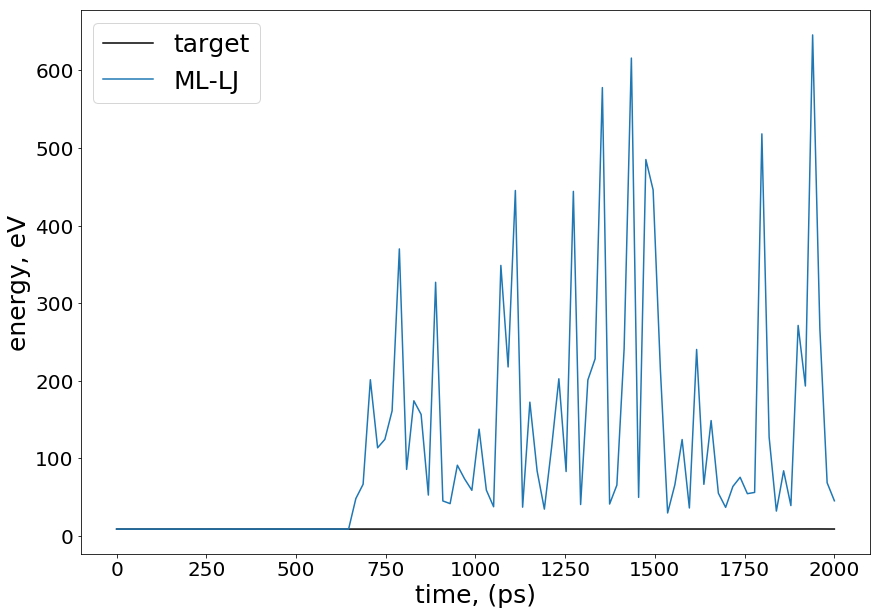

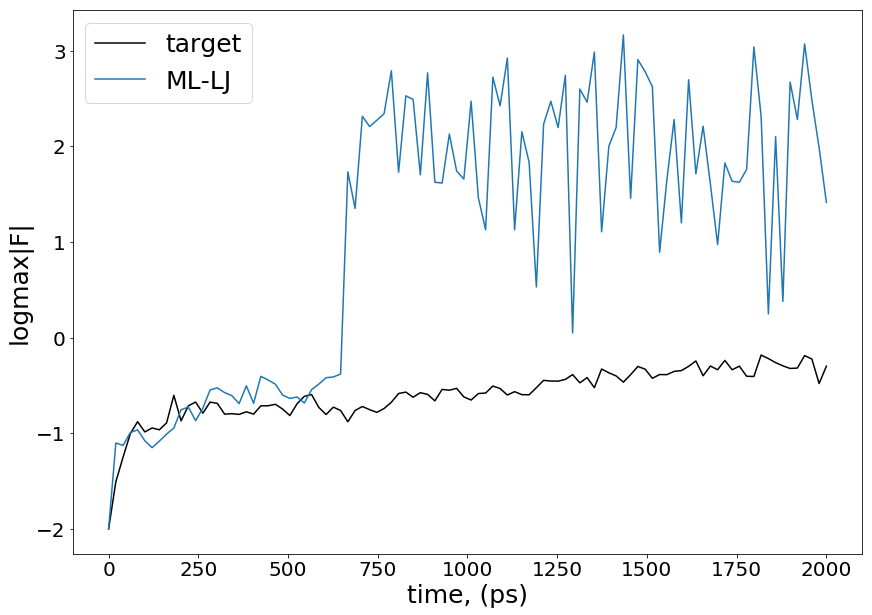

In [52]:
# Time Plots
import matplotlib.pyplot as plt
%matplotlib inline

time_plots(emt_energy, [ml_actual_energy], None, ['ML-LJ'], 'energy', None )
time_plots(emt_forces, [ml_actual_forces], None, ['ML-LJ'], 'forces', None )

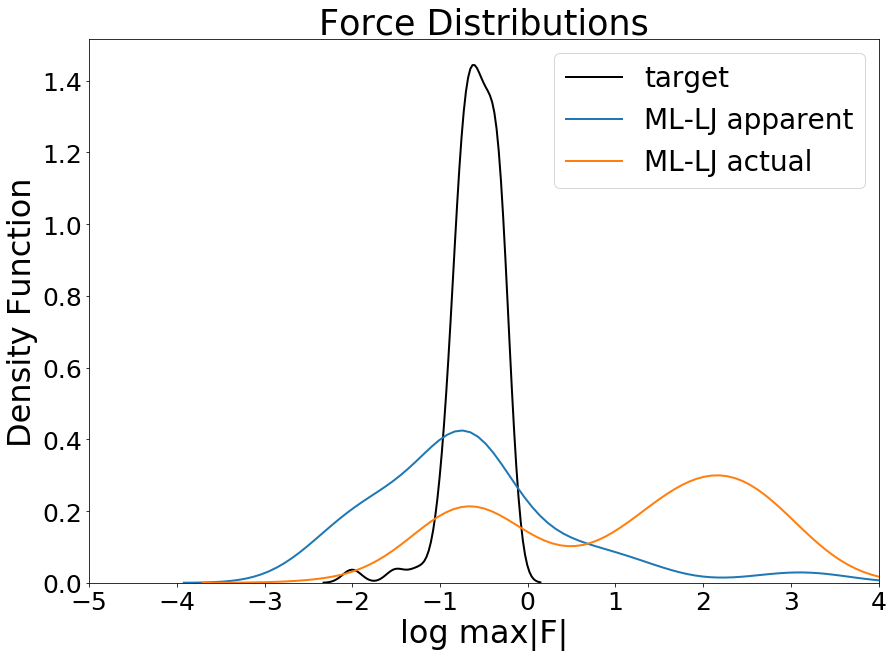

In [53]:
kde_plots(emt_forces, [ml_apparent_forces, ml_actual_forces] , ['ML-LJ apparent', 'ML-LJ actual'])

In [ ]:
# Resample MD Simulation
import random
import copy
sample_points = random.sample(range(1, len(ml_images)), 10) #sample 10 points
images = ase.io.read("../../datasets/COCu/COCu_pbc_300K.traj", ":100")
resampled_images = copy.copy(images)
for i in sample_points:
    ml_image = ml_images[i].copy()
    ml_image.set_calculator(EMT())
    resampled_images.append(ml_image)

# Define Training data
label = "skorch_resample"
lj_data = lj_optimization(resampled_images, Gs, label)
forcetraining = True
training_data = AtomsDataset(images, Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=1, lj_data=lj_data)
scalings = training_data.scalings
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

# Train
net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 30, 30], device, forcetraining=forcetraining),
    criterion=TanhLoss,
    criterion__force_coefficient=0.3,
    optimizer=torch.optim.Adam,
    lr=1e-2,
    batch_size=20,
    max_epochs=500,
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=True,
    iterator_valid__collate_fn=collate_amp,
    iterator_valid_shuffle=False,
    device=device,
    train_split=CVSplit(0.2),
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=True,
            use_caching=True,
            target_extractor=target_extractor,
        ), cp, load_best_valid_loss, LR_schedule
    ],
)

# Define calculator and train
calc = AMP(training_data, net, label=label)
calc.train(overwrite=True)

In [ ]:
# MD Simulation
md_run(calc=calc, starting_image=images[0].copy(), temp=300, count=100, label=label)

In [ ]:
# Calculate forces of base and generated trajectory
ml_resample_images = ase.io.read(label+".traj", ":")
emt_energy, ml_r_apparent_energy, ml_r_actual_energy = calculate_energies(images, ml_resample_images)
emt_forces, ml_r_apparent_forces, ml_r_actual_forces = calculate_forces(images, ml_resample_images, type="max")

In [ ]:
# Time Plots

time_plots(emt_energy, [ml_actual_energy, ml_r_actual_energy], None, ['ML-LJ', 'ML-LJ resample'], 'energy', None )
time_plots(emt_forces, [ml_actual_forces, ml_r_actual_forces], None, ['ML-LJ', 'ML-LJ resample'], 'forces', None )

In [ ]:
kde_plots(emt_forces, [ml_actual_forces, ml_r_actual_forces] , ['ML-LJ', 'ML-LJ resample'])